In [1]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


## Generator 및 Discriminator 구현

In [2]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 전치 합성곱 층에 넣으므로 텐서 형태로 변형
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out


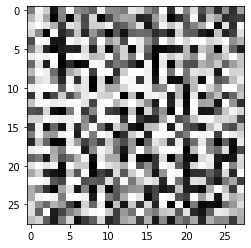

In [3]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# 입력 난수
# 배치 노멀라이제이션이 있으므로, 미니 배치 수는 2 이상
input_z = torch.randn(2, 20)

# 가짜 화상을 출력
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


In [4]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 화상 측 입력 처리
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 난수 측 입력 처리
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 최후 판정
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 화상 측 입력 처리
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 난수 측 입력 처리
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_out과 z_out을 결합하여, 전결합층에서 판정
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 최후에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1)  # 2차원으로 변환

        out = self.last2(out)

        return out, feature


In [5]:
# 동작 확인
D = Discriminator(z_dim=20)

# 가짜 화상 생성
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out, _ = D(fake_images, input_z)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))


tensor([[0.4322],
        [0.4629]], grad_fn=<SigmoidBackward>)


## Encoder 구현

In [6]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # 여기까지 화상 크기는 7×7이 되어 있다
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FC에 넣기 위해 텐서 형으로 변형
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out


In [7]:
# 동작 확인
E = Encoder(z_dim=20)

# 입력할 화상 데이터
x = fake_images  # fake_images는 위에서 G로 작성한 것

# 화상에서 z를 Encode
z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.0669, -0.2844, -0.3601,  0.1404, -0.2922, -0.4834, -0.0025,  0.0258,
         -0.1298, -0.2613, -0.4292, -0.2584, -0.6141, -0.1440,  0.1142,  0.2175,
          0.0730,  0.0323, -0.7176, -0.7410],
        [ 0.4822,  0.3681, -0.0647, -0.0773,  0.0989,  0.3012,  0.8054,  0.4399,
          1.0848, -0.2809,  0.0619, -0.3179, -0.2963, -0.1192,  0.6562, -0.1707,
          0.1287, -0.6156,  0.3127, -0.4819]], grad_fn=<AddmmBackward>)


## 데이터로더 구현

In [8]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [9]:
class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [10]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed


In [11]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 28, 28])


## Efficient GAN 학습

In [15]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, E, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 오차함수 정의
    # BCEWithLogitsLoss는 입력에 시그모이드(logit)을 곱한 뒤에,
    # 이진 크로스 엔트로피를 계산
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    E.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_e_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # 미니 배치 크기의 1 또는 0의 라벨 역할의 텐서를 작성
            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            label_real = label_real.float()
            label_fake = label_fake.float()


            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 진짜 화상을 판정　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder 학습
            # --------------------
            # 진짜 화상 z를 추정
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 오차를 계산
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("총 반복 횟수: ", iteration)

    return G, D, E


In [16]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 전결합층 Linear 초기화
        m.bias.data.fill_(0)


# 초기화 실시
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [17]:
num_epochs = 1500
G_update, D_update, E_update = train_model(G,D,E, dataloader=train_dataloader, num_epochs=num_epochs)

사용 장치:  cuda:0
-------------
Epoch 0/1500
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1483 ||Epoch_G_Loss:0.0788 ||Epoch_E_Loss:0.0767
timer:  0.4136 sec.
-------------
Epoch 1/1500
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1448 ||Epoch_G_Loss:0.0811 ||Epoch_E_Loss:0.0784
timer:  0.2304 sec.
-------------
Epoch 2/1500
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1409 ||Epoch_G_Loss:0.0832 ||Epoch_E_Loss:0.0807
timer:  0.2480 sec.
-------------
Epoch 3/1500
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.1362 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.0844
timer:  0.2510 sec.
-------------
Epoch 4/1500
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1324 ||Epoch_G_Loss:0.0863 ||Epoch_E_Loss:0.0871
timer:  0.2374 sec.
-------------
Epoch 5/1500
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.1307 ||Epoch_G_Loss:0.0881 ||Epoch_E_Loss:0.0878
timer:  0.2562 sec.
-------------
Epoch 6/1500
----------

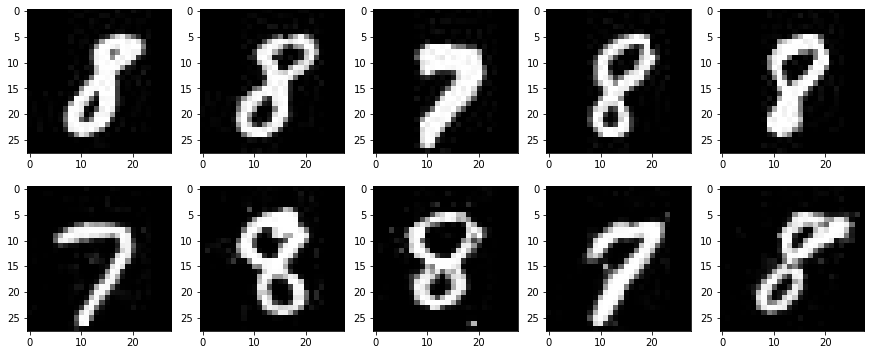

In [21]:
# 생성 화상과 훈련 화상을 시각화한다
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


## Efficient GAN을 활용한 이상탐지

In [22]:
# 테스트용 DataLoader 작성
def make_test_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# 파일 리스트를 작성
test_img_list = make_test_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


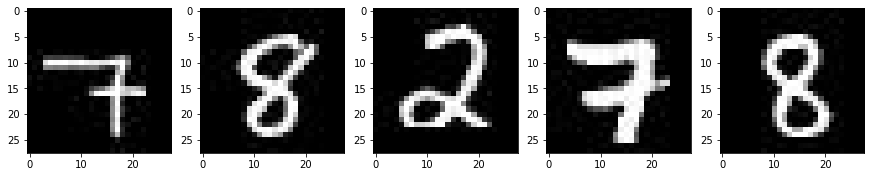

In [23]:
# 테스트 데이터 확인
batch_iterator = iter(test_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 훈련 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [24]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, x_feature = D(x,z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    discriminato_loss = torch.abs(x_feature - G_feature)
    discriminato_loss = discriminato_loss.view(discriminato_loss.size()[0], -1)
    discriminato_loss = torch.sum(discriminato_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discriminato_loss

    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

total loss:  [269. 129. 276. 238. 157.]


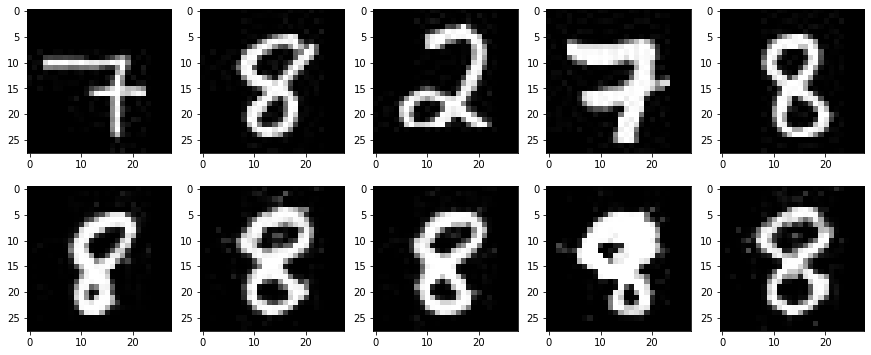

In [25]:
# 이상 탐지할 화상
x = imges[0:5]
x = x.to(device)

# 지도 데이터의 화상을 Encode하여 z로 한 뒤, G에서 생성
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 손실을 구한다
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 손실 계산. 총 촌실
loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 화상을 시각화
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')
